<h1> How can smart sampling accelerate the prediction of the spinodal for a system undergoing liquid liquid phase separation?</h1>
<p> Mean field theory based on this paper: https://pubs.acs.org/doi/pdf/10.1021/acs.jpcb.0c00402 </p>

<p> Suppose that experimental data was costly, and it was desirable to minimise the amount of experimental data needed to predict the spinodal of a two component mixture. One could of course sample random points in two dimensional composition space, but there might be a better way. A candidate alternative would be to use active machine learning -- that is to train a model on a small set of datapoints, then request the set of points the model is least sure about. Typically, we might expect those points to lie fairly close to the boundary. This process could then be iterated -- the model is fitted -- it tells the experimenter where it is uncertain -- then the experimenter provides new points, chosen from the location in composition space where the model would be helped the most.</p>

<p> I've hacked together a super simple demonstration of this, based on using an analytically solvable phase diagram for LLPS, with a Random Forest Classifier being the ML model which undergoes active learning.</p>

The analytical model is based on the paper  "Simple Calculation of Phase Diagrams for Liquid−Liquid Phase
Separation in Solutions of Two Macromolecular Solute Species" (Allen P. Minton, 2020, The Journal of Physical Chemistry B).

<h2> Calculating the true phase diagram </h2>

(0.0, 1.0)

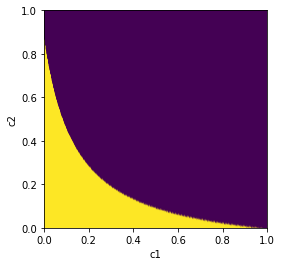

In [370]:
#pairwise interaction potentials

B11 = -1
B12 = 3
B22 = -1
B111 = 0
B112 = 0
B122 = 0
B222 = 0

def get_log_gamma2_by_c2(c1,c2):
    return B22 + 2*B122*c1+2*B222*c2
def get_log_gamma1_by_c1(c1,c2):
    return B11 + 2*B111*c1+2*B112*c2
def get_log_gamma1_by_c2(c1,c2):
    return B12+2*B112*c1+2*B122*c2

def get_phase(c1,c2):
    x = ((1+c2*get_log_gamma2_by_c2(c1,c2))*(1+c1*get_log_gamma1_by_c1(c1,c2)) - 
            c1*c2*(get_log_gamma1_by_c2(c1,c2))**2)
    return x > 0

import numpy as np

c1_array = np.linspace(0,1,300)
c2_array = np.linspace(0,1,300)

x = []
y = []
phase = []

for c1 in c1_array:
    for c2 in c2_array:
        x.append(c1); y.append(c2); phase.append(get_phase(c1,c2))

import matplotlib.pyplot as plt
%matplotlib inline

#phase boundary
f,ax = plt.subplots(1,1,figsize = (4,4))
plt.scatter(x,y,c = phase)
ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

In [371]:
#let's generate some random points, and work out which phase they are?

<h2> Sampling randomly -- not very efficient </h2>

Text(0, 0.5, 'c2')

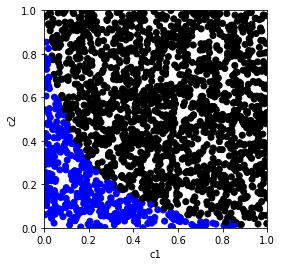

In [372]:
x = []
y = []
phase = []
colors = []

f,ax = plt.subplots(1,1,figsize = (4,4))

for i in range(2000):

    c1 = np.random.rand()
    c2 = np.random.rand()
    p = get_phase(c1,c2)

    if p == 0: c = (0,0,0)
    else: c = (0,0,1)
    
    x.append(c1)
    y.append(c2)
    phase.append(p)
    colors.append(c)


ax.scatter(x,y,c= colors)    
    
ax.set_xlim (0,1)
ax.set_ylim(0,1)

ax.set_xlabel('c1')
ax.set_ylabel('c2')

<h2> Plotting the decision boundaries of a Random Forest trained to reproduce the training data </h2>

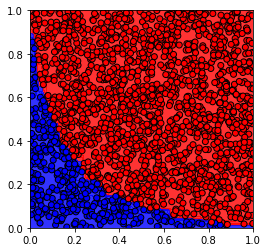

In [373]:
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(['#FF0000', '#0000FF'])

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

#clf = SVC(kernel = "rbf", gamma = "scale", C = 0.2)

X = np.array(list(zip(x,y)))

f,ax = plt.subplots(1,1,figsize = (4,4))

clf.fit(X, phase)

clf.predict([[0,0]])

score = clf.score(X,phase)

xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

ax.scatter(X[:, 0], X[:, 1], c=phase, cmap=cm_bright,
                   edgecolors='k')

<h1> Useing a greedy acActive Learning </h1>

In [354]:
#now let's use an active learning approach!

In [359]:
clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

for _ in range(100):
    clf.fit(X_ours, phase_ours)

    sample = X[np.argmin(np.abs(clf.predict_proba(X)[:,0]-0.5))] 

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))

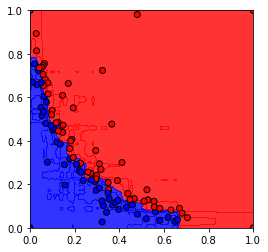

In [361]:
f,ax = plt.subplots(1,1,figsize = (4,4))

X_ours = np.array(X_ours)

xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                         np.linspace(0, 1, 100))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)


ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                   edgecolors='k')

<h1> Decision boundary as number of samples change for (greedy) active learning system </h1>

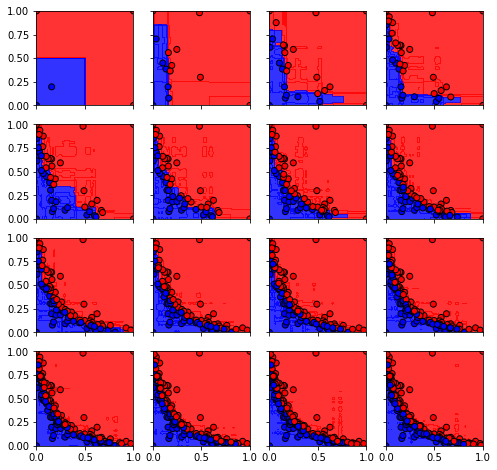

In [366]:
f,ax = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

for _ in range(160):

    clf.fit(X_ours, phase_ours)

    sample = X[np.argmin(np.abs(clf.predict_proba(X)[:,0]-0.5))] 

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))
    
    if _%10 == 0:
        
        our_ax = ax.flatten()[int(_/10)]

        X_ours = np.array(X_ours)

        xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                                 np.linspace(0, 1, 100))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)


        our_ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

        our_ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                           edgecolors='k')
    X_ours = list(X_ours)

<h1> Decision boundary as number of samples change for naive random point system </h1>

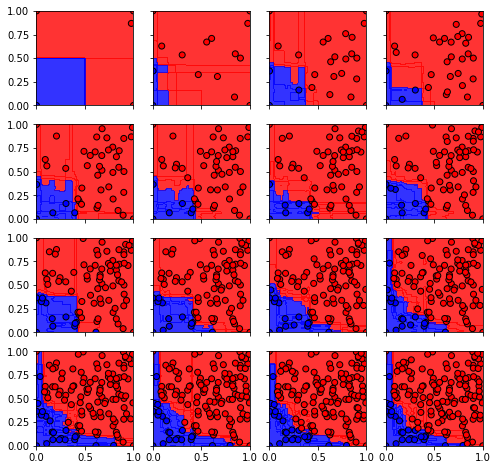

In [367]:
f,ax = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

clf = RandomForestClassifier()

X_ours = [[0,0],[0,1],[1,0],[1,1]]
phase_ours = [get_phase(x1,x2) for x1,x2 in X_ours]
numbers = [str(i) for i in range(4)]

for _ in range(160):

    clf.fit(X_ours, phase_ours)

    sample = [np.random.rand(),np.random.rand()]

    X_ours.append(sample)
    
    new_phase = get_phase(sample[0],sample[1])
    phase_ours.append(new_phase)
    numbers.append(str(_+4))
    
    if _%10 == 0:
        
        our_ax = ax.flatten()[int(_/10)]

        X_ours = np.array(X_ours)

        xx, yy = np.meshgrid(np.linspace(0, 1, 100),
                                 np.linspace(0, 1, 100))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)


        our_ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=.8)

        our_ax.scatter(X_ours[:, 0], X_ours[:, 1], c=phase_ours, cmap=cm_bright,
                           edgecolors='k')
    X_ours = list(X_ours)